**Making a script to input .mca or .spe files to and output some lovely spectrum**

In [4]:
filename = "abcdefg.spe"
filename[-3:]

'spe'

In [68]:
#%%writefile spectrum_reader.py
"""
spectrum_reader.py

This will read in spe or mca files from our detectors and make us some lovely background subtracted spectra


"""
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import pandas as pd

def file_type_checker(filename):
    """checks the file type, because the header will have diff formatting"""
    
    if filename[-3:] == "Spe":
        return "Spe"
    elif filename[-3:] == "mca":
        return "mca"
    else: return "error"

def file_parser(filename):

    #the function will fill and return these dictionaries:
    
    header_dict = {
        "DATE_MEAS": [],
        "MEAS_TIME": []
    }

    spectrum_dict = {
        "bins": [], 
        "counts": []
    }

    if file_type_checker(filename) == "Spe" :
        IS_DATA = False

        with open(filename, "r") as file:
            for line in file:
                line = line.strip()

            # if it's data, reset the flag
                if line == '$DATA:':
                    IS_DATA = True
                    continue
                elif line.startswith('$MEAS_TIM:'):
                    next_line = next(file).split(" ")
                    header_dict["MEAS_TIME"].append(float(next_line[0]))
                    IS_DATA = False
                elif line.startswith('$DATE_MEA:'):
                    next_line = next(file).strip()
                    header_dict["DATE_MEAS"].append(next_line)
                    IS_DATA = False

            #this is for all lines following # DATA
            #while IS_DATA == True:  
                if IS_DATA == True:
                    try:
                        spectrum_dict["counts"].append(float(line))
                    except ValueError:
                        continue   
        #change if bin range changes
        for i in range(len(spectrum_dict["counts"])):
            spectrum_dict["bins"].append(i)
        
        return header_dict, spectrum_dict

    elif  file_type_checker(filename) == "mca" :
        IS_DATA = False

        with open(filename, "r") as file:
            for line in file:
                line = line.strip()
    
                # if it's data, reset the flag
                if line.startswith('<<DATA>>'):
                    IS_DATA = True
                    continue
                elif line.startswith('REAL_TIME'):
                    line = line.strip()
                    header_dict["MEAS_TIME"].append(float(line[12:]))
                    IS_DATA = False
                elif line.startswith('START_TIME'):
                    line = line.strip()
                    header_dict["DATE_MEAS"].append(line[13:])
                    IS_DATA = False
                elif line.startswith("<<END>>"):
                    IS_DATA = False
                # else:
                #     print('hang on a sec')
                #     print(line)
    
                #this is for all lines following # DATA
                #while IS_DATA == True:  
                if IS_DATA == True:
                    try:
                        spectrum_dict["counts"].append(int(line))
                    except Exception as e:
                        print(e)
                        continue   
        #change if bin range changes
        for i in range(len(spectrum_dict["counts"])):
            spectrum_dict["bins"].append(i)
        
        return header_dict, spectrum_dict

    elif file_type_checker(filename) == "error":
        print("give me the right file type (mca or spe) pretty please!")

def background_subtract(data, background):
    """
    Converts soectrum to units of counts/sec then subtracts background from data
    Inputs: data file, backgound file (.spe or .mca files)
    Outputs: dataframe object of bins and counts per second of background subtracted spectra
    """
    data_header, data_spectrum = file_parser(data)
    background_header, background_spectrum = file_parser(background)

    background_ct = background_header["MEAS_TIME"]
    data_ct = data_header["MEAS_TIME"]

    background_subtracted = (np.array(data_spectrum["counts"]) / data_ct) - (np.array(background_spectrum["counts"]) / background_ct)

    table = {
        'bins' : data_spectrum["bins"],
        'counts/sec' : background_subtracted
    }

    return pd.DataFrame(table)

In [69]:
bg_sub_table = background_subtract("experimental_NaI/Am_0degree.Spe", "experimental_NaI/Buffer_Data.Spe")

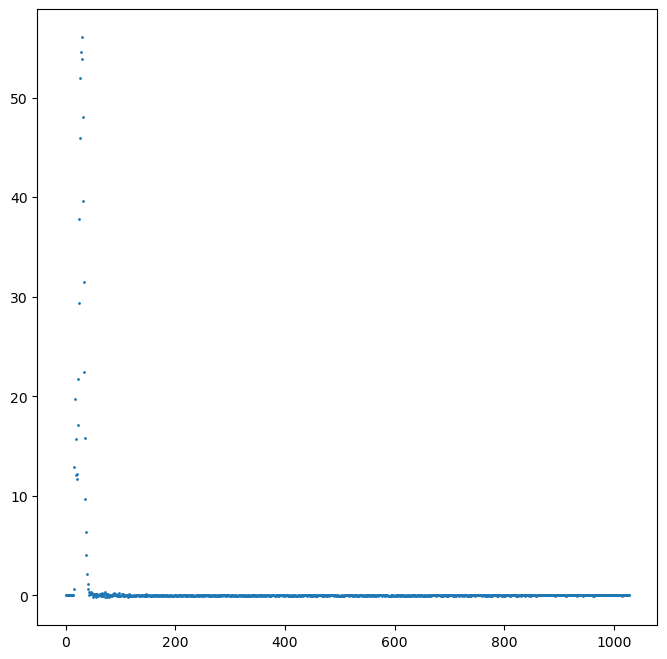

In [70]:
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(bg_sub_table["bins"], bg_sub_table["counts/sec"], s = 1)

In [71]:
bg_sub_table = background_subtract("experimental CdTe/Am_CdTe_0deg.mca", "experimental CdTe/Background_CdTe.mca")

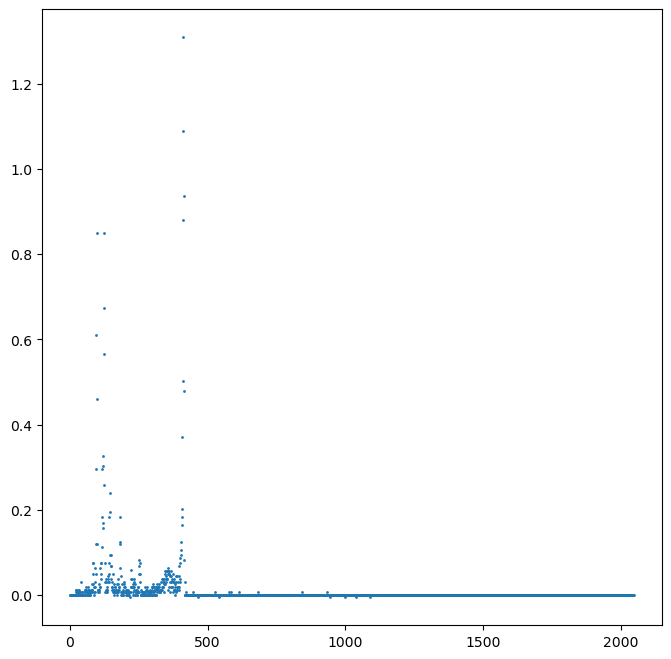

In [72]:
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(bg_sub_table["bins"], bg_sub_table["counts/sec"], s = 1)